## ECE 143 Group 8 - Visualization Generation

Combining code from AADT_DataVisualization-Scott.ipynb, i5_prediction_map_kexin.ipynb, and cnty_map.ipynb

In [1]:
import folium
import branca.colormap as cm
import io
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

### Slides 5 and 6 - AADT Graphs 
* From AADT_DataVisualization-Scott.ipynb

In [3]:
# Setting default figure size
plt.rcParams['figure.figsize'] = [20, 10]

# df = pd.read_csv('C:/Users/zyplo/Documents/GitHub/ECE 143/ECE143_Group8/Data/pranav_cleaned_data/AADT/combined_aadt_2017_2022.csv')
df = pd.read_csv('All Files/Data/pranav_cleaned_data/AADT/combined_aadt_2017_2022.csv')
# print("Head: \n", df.head(), "\n")
# print("Describe: \n", df.describe(), "\n")
# print("Value Counts: \n", df.value_counts(), "\n")

# Adding total hour/monthy/AADT counts to dataframe (ex. TOTAL_PEAK_HOUR = BACK_PEAK_HOUR + AHEAD_PEAK_HOUR)
df.insert(8, 'TOTAL_PEAK_HOUR', df['BACK_PEAK_HOUR'] + df['AHEAD_PEAK_HOUR'])
df.insert(9, 'TOTAL_PEAK_MADT', df['BACK_PEAK_MADT'] + df['AHEAD_PEAK_MADT'])
df.insert(10, 'TOTAL_AADT', df['BACK_AADT'] + df['AHEAD_AADT'])

# Removing all rows with PEAK_HOUR, PEAK_MADT, AADT NaN values
df.dropna(subset=['BACK_PEAK_HOUR', 'BACK_PEAK_MADT', 'BACK_AADT', 'AHEAD_PEAK_HOUR', 'AHEAD_PEAK_MADT', 'AHEAD_AADT'])

# Creating a sub-dataframe with only San Diego County data
sd_df = df[df['CNTY'] == 'SD'] 

# Creating dataframe for truck-specific AADT data
# truck_df = pd.read_csv('C:/Users/zyplo/Documents/GitHub/ECE 143/ECE143_Group8/Data/pranav_cleaned_data/truck_AADT/combined_truck_aadt_2017_2022.csv')
truck_df = pd.read_csv('All Files/Data/pranav_cleaned_data/truck_AADT/combined_truck_aadt_2017_2022.csv')

# Removing all rows with RTE, TRK_PERCENT_TOT, YEAR NaN values
truck_df.dropna(subset=['RTE', 'TRK_PERCENT_TOT', 'YEAR'])

# Converting all routes to strings, unifying route number formatting
truck_df['RTE'] = truck_df['RTE'].astype(str)
truck_df['RTE'] = truck_df['RTE'].str.lstrip('0')

# Creating sub-dataframe with routes of interest
sub_truck_df = truck_df[truck_df['RTE'].isin(['5', '8', '10', '15', '40', '80'])].copy()

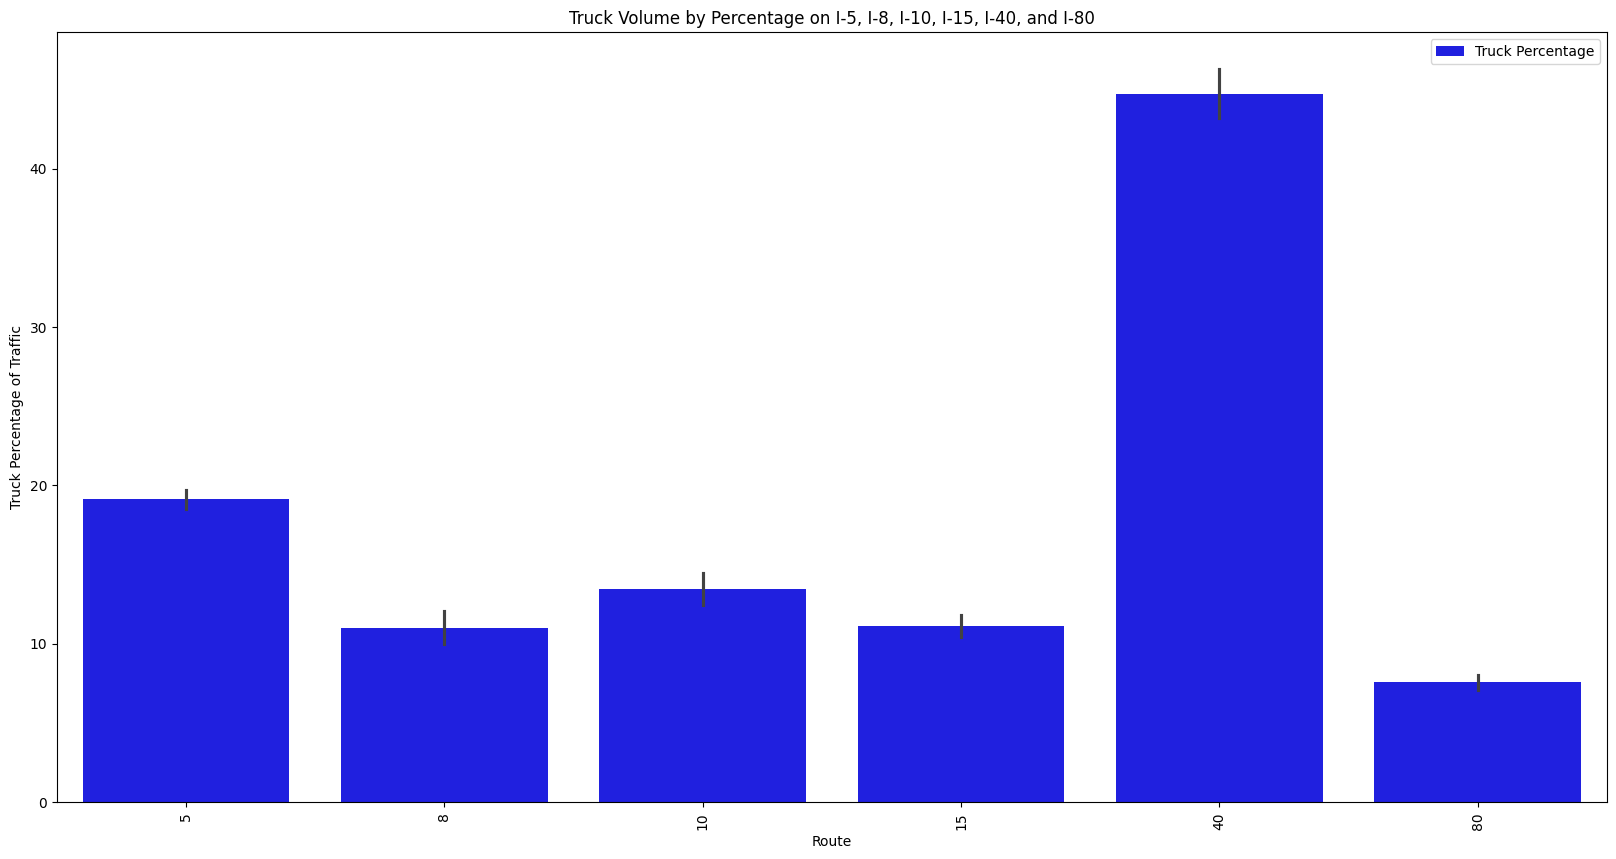

In [4]:
# Slide 5: Plot of truck volume by percentage on I-5, I-8, I-10, I-15, I-40, and I-80
sns.barplot(x='RTE', y='TRK_PERCENT_TOT', data=sub_truck_df, color='blue', label='Truck Percentage')
plt.pyplot.xlabel('Route')
plt.pyplot.ylabel('Truck Percentage of Traffic')
plt.pyplot.title('Truck Volume by Percentage on I-5, I-8, I-10, I-15, I-40, and I-80')
plt.pyplot.legend()
plt.pyplot.xticks(rotation=90)
plt.pyplot.show()

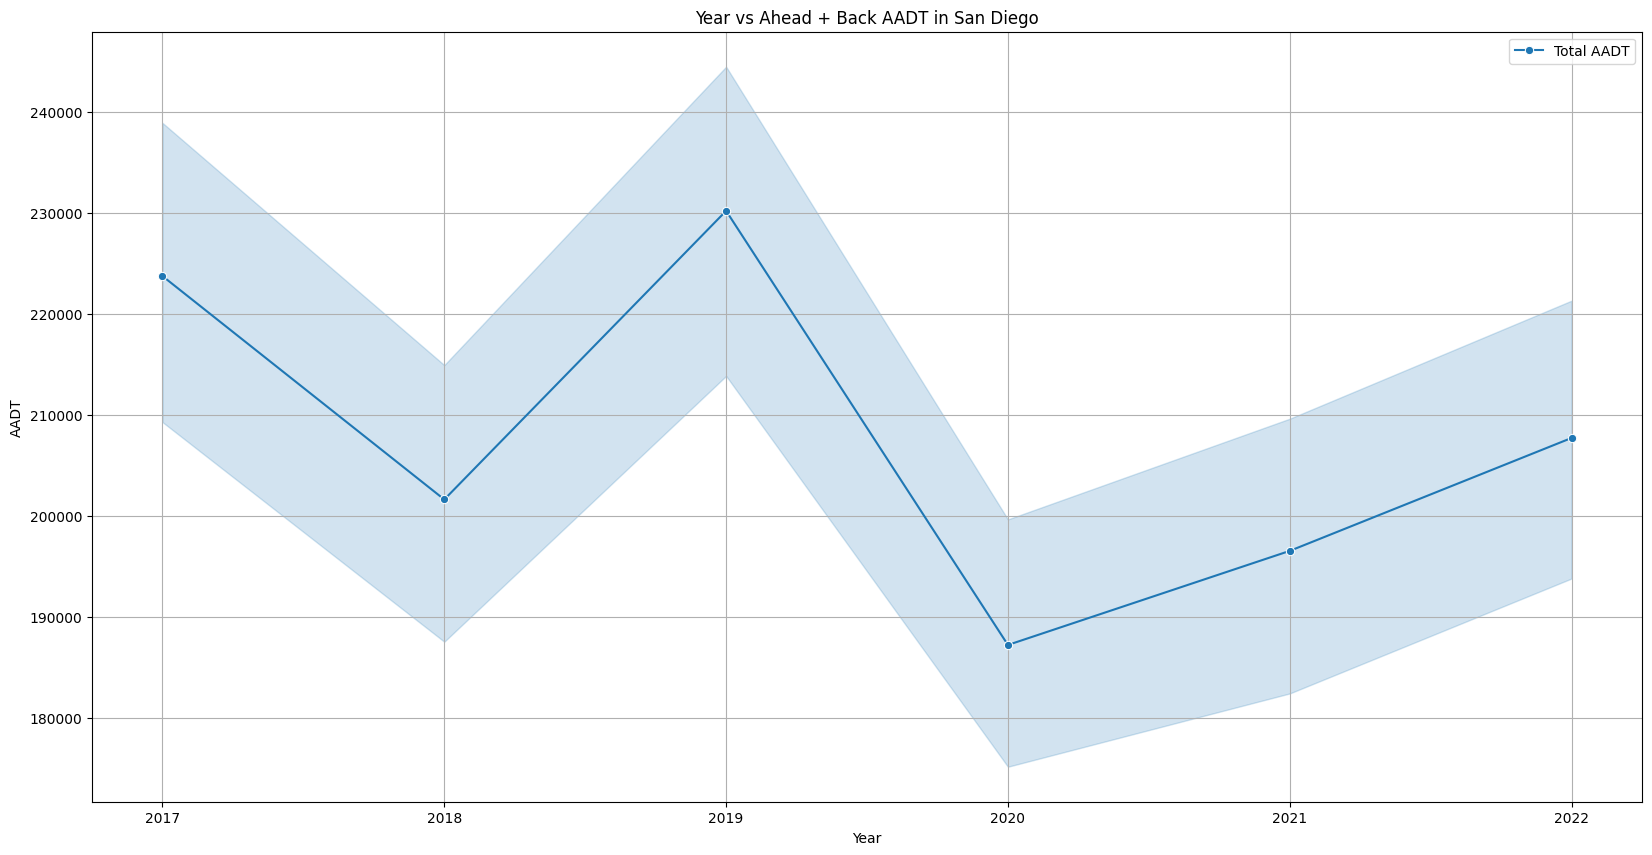

In [5]:
# Slide 6 Graph 1: Year vs Ahead + Back AADT in San Diego
sns.lineplot(x='YEAR', y='TOTAL_AADT', data=sd_df, marker='o', label='Total AADT')
plt.pyplot.xlabel('Year')
plt.pyplot.ylabel('AADT')
plt.pyplot.title('Year vs Ahead + Back AADT in San Diego')
plt.pyplot.legend()
plt.pyplot.grid(True)
plt.pyplot.show()

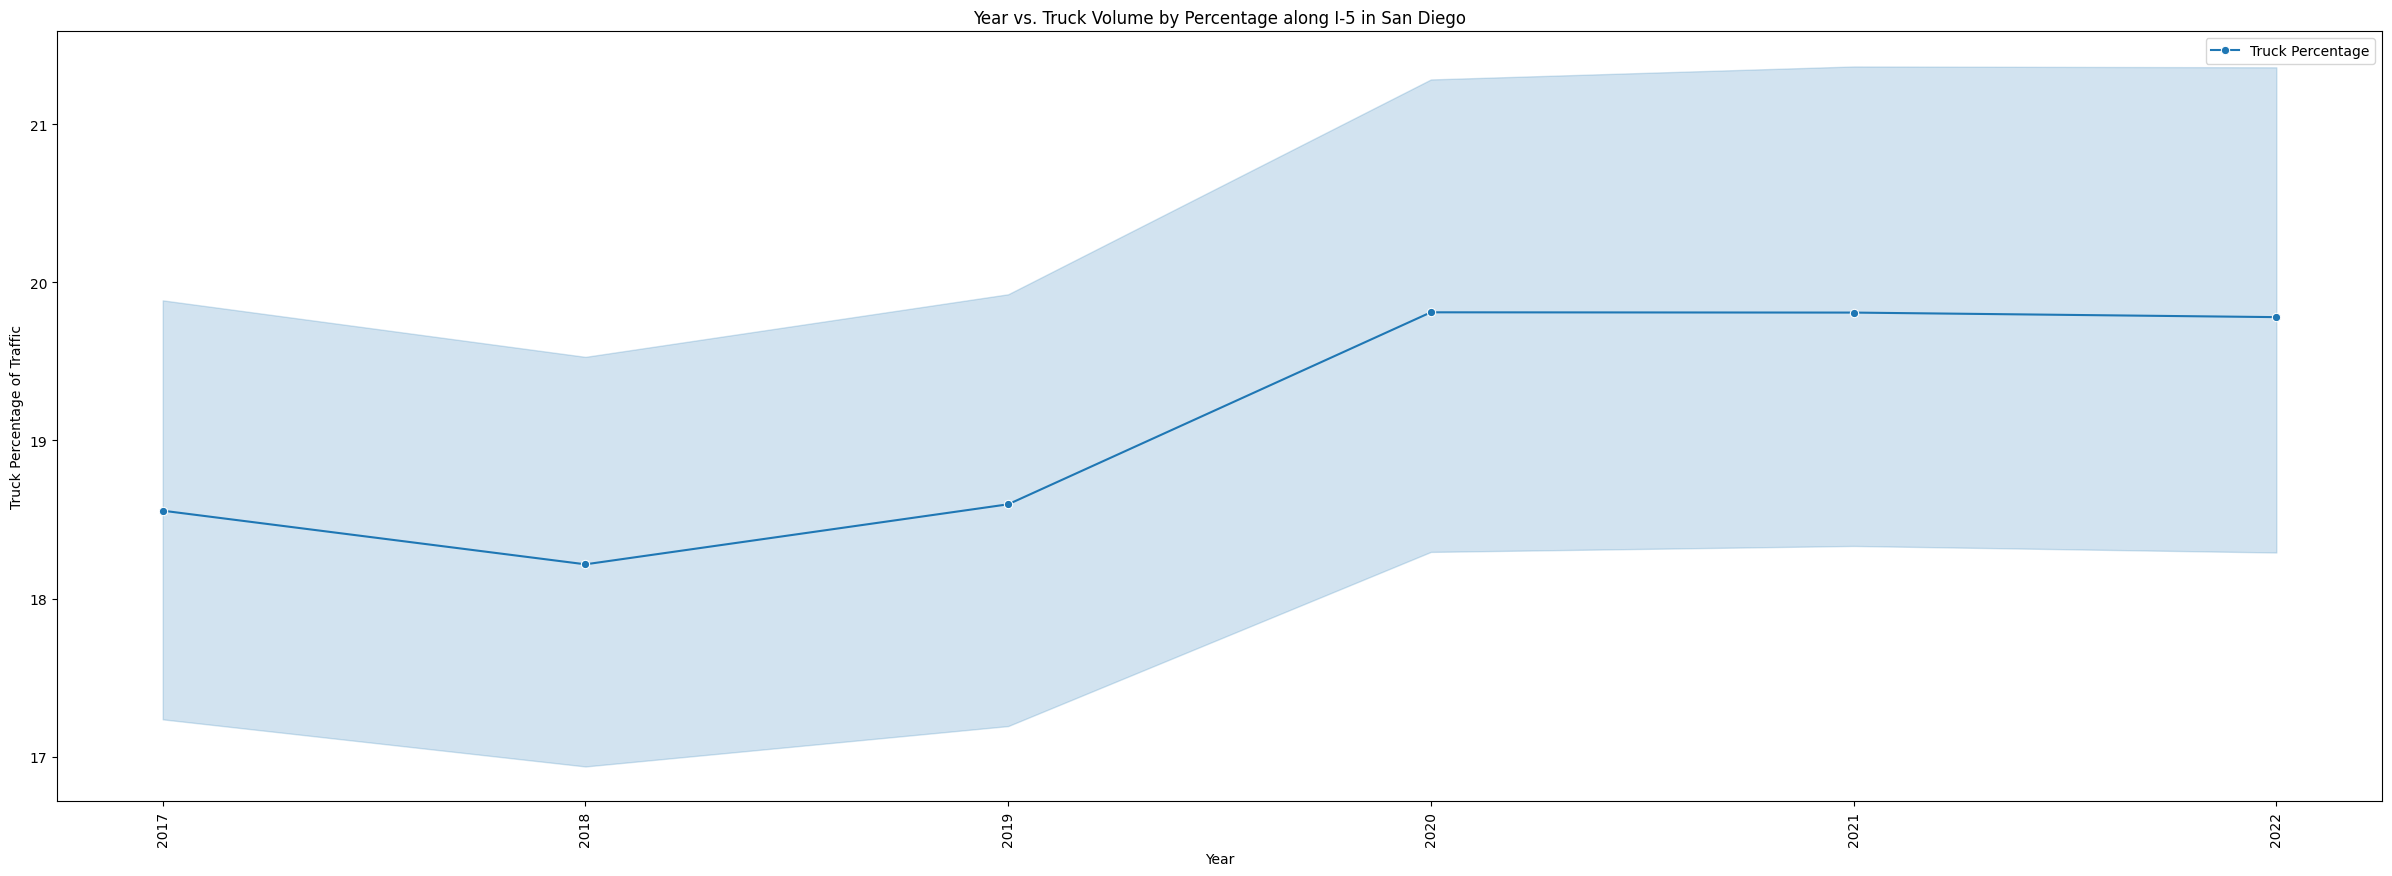

In [6]:
# Slide 6 Graph 2: Year vs. Plot of truck volume by percentage along I-5
sub_truck_df_rte5 = sub_truck_df[sub_truck_df['RTE'] == '5']
sub_truck_df_rte5_SD = sub_truck_df_rte5[sub_truck_df_rte5['CNTY'] == 'SD']
fig, ax = plt.pyplot.subplots(figsize=(30, 10))
sns.lineplot(x='YEAR', y='TRK_PERCENT_TOT', data=sub_truck_df_rte5, marker='o', label='Truck Percentage')
plt.pyplot.xlabel('Year')
plt.pyplot.ylabel('Truck Percentage of Traffic')
plt.pyplot.title('Year vs. Truck Volume by Percentage along I-5 in San Diego')
plt.pyplot.legend()
plt.pyplot.xticks(rotation=90)
plt.pyplot.show()

### Slide 7 - AADT Heatmap for LA, SD, and Orange County
* From i5_prediction_map_kexin.ipynb: County Map AADT - Kexin

In [7]:
def generate_aadt_map(csv_file, num_subsegments=10):
    """
    Generate a scatter map of AADT (Annual Average Daily Traffic) with colors varying by AADT value based on a CSV file.
    
    Parameters:
    - csv_file (str): Path to the CSV file, which must contain the columns "Latitude", "Longitude", and "VEHICLE_AADT_TOTAL".
    
    Returns:
    - folium.Map object
    """
    # 1. Read the CSV file
    df = pd.read_csv(csv_file)
    df["Longitude"] = -df["Longitude"] 
    filtered_df =  df[(df["CNTY"].isin(["SD", "LA", "ORA"])) & (df["Year"] == 2023)].copy()
    filtered_df["POSTMILE_DIFF"] = filtered_df["POSTMILE"].diff()
    filtered_df = filtered_df[filtered_df["POSTMILE_DIFF"] < 2]  

    
    # 2. Create a Folium map (set the center to the mean of coordinates)
    m = folium.Map(
        location=[filtered_df["Latitude"].mean(), filtered_df["Longitude"].mean()], 
        zoom_start=7, 
        tiles="OpenStreetMap"
    )

    # 3. Create a color map (for the scatter plot with a gradient of AADT values)
    colormap = cm.LinearColormap(
        colors=["blue", "green", "yellow", "red"],  
        vmin=filtered_df["AADT"].min(),  
        vmax=filtered_df["AADT"].max()
    )

    # 4. Loop through the data and plot the scatter points
    # 4绘制平滑渐变线条
    for i in range(len(filtered_df) - 1):
        lat1, lon1, aadt1 = filtered_df.iloc[i][["Latitude", "Longitude", "AADT"]]
        lat2, lon2, aadt2 = filtered_df.iloc[i + 1][["Latitude", "Longitude", "AADT"]]

        # 生成经纬度插值（细分线段）
        lats = np.linspace(lat1, lat2, num_subsegments)
        lons = np.linspace(lon1, lon2, num_subsegments)
        aadts = np.linspace(aadt1, aadt2, num_subsegments)  # AADT 也插值，使颜色渐变

        # 画小线段（颜色渐变）
        for j in range(num_subsegments - 1):
            color = colormap(aadts[j])  # 计算当前小线段的颜色

            folium.PolyLine(
                locations=[(lats[j], lons[j]), (lats[j + 1], lons[j + 1])],
                color=color,
                weight=5,
                opacity=0.8
            ).add_to(m)

    # 5添加 AADT 颜色图例
    colormap.caption = "predicted AADT Traffic Data in 2023"
    colormap.add_to(m)

    # 6返回地图对象
    return m

In [10]:
aadt_map = generate_aadt_map("All Files/County Map AADT - Kexin/predicted_AADT_2023-2025.csv")  
display(aadt_map)

### Slides 8 and 9 - Peak Traffic Volume Hourly Heatmaps
* From cnty_map.ipynb: County Map Peak Hour - Ian

In [9]:
def generate_peakhour_map_point(csv_file, hour):
    """
    Generate a scatter map of Peak Hourly Volume(PHV) with colors varying by PHV value based on a CSV file.
    
    Parameters:
    - csv_file (str): Path to the CSV file, which must contain the columns "LATITUDE", "LONGITUDE", "HOUR" and "PHV".
    
    Returns:
    - folium.Map object
    """
    # 1. Read the CSV file
    df = pd.read_csv(csv_file)
    filtered_df = df.copy()

    # Calculate the difference in POSTMILE values
    filtered_df["POSTMILE_DIFF"] = filtered_df["PM"].diff()
    
    # Filter only rows where the hour is the given hour
    filtered_df = filtered_df[filtered_df["HOUR"] == hour]

    # Keep only rows where the difference is >= 2
    filtered_df = filtered_df[filtered_df["POSTMILE_DIFF"] >= 2]

    # 2. Create a Folium map (set the center to the mean of coordinates)
    m = folium.Map(
        location=[df["LATITUDE"].mean() + 0.5, df["LONGITUDE"].mean()], 
        zoom_start=8, 
        tiles="OpenStreetMap"
    )

    # 3. Create a color map (for the scatter plot with a gradient of PHV values)
    colormap = cm.LinearColormap(
        colors=["blue", "green", "yellow", "red"],  
        vmin=df["PHV"].min(),  
        vmax=df["PHV"].max()
    )

    # 4. add legend to the map
    colormap.caption = "PHV traffic data"
    colormap.add_to(m)

    if filtered_df.empty:
        print(f"No data for hour {hour}")
        return m

    # 5. Loop through the data and plot the scatter points
    for _, row in filtered_df.iterrows():
        lat, lon, PHV = row["LATITUDE"], row["LONGITUDE"], row["PHV"]
        color = colormap(PHV) # Calculate color based on PHV value

        folium.CircleMarker(
            location=(lat, lon),
            radius=4,  # Marker size
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.8,
            popup=folium.Popup(f"PHV: {PHV}", parse_html=True)  # Display PHV value on hover
        ).add_to(m)

    # 6. Return the map object
    return m

In [12]:
for i in range(0, 24):
    PHV_map = generate_peakhour_map_point('All Files/County Map Peak Hour - Ian/peak_hour_with_coordinates.csv', i)
    if PHV_map is None:
        print(f"Hour {i} done")
        continue
    map_title = f"Peak Traffic Volume Hour {i}"
    title_html = f'<h1 style="position:absolute;z-index:100000;left:20vw" >{map_title}</h1>'
    PHV_map.get_root().html.add_child(folium.Element(title_html))
    img_data = PHV_map._to_png(5)
    img = Image.open(io.BytesIO(img_data))
    # img.save(f'Hour_{i}.png')
    print(f"Hour {i} done")
    display(PHV_map)

No data for hour 0
Hour 0 done


Hour 1 done


No data for hour 2
Hour 2 done


No data for hour 3
Hour 3 done


No data for hour 4
Hour 4 done


Hour 5 done


Hour 6 done


Hour 7 done


Hour 8 done


Hour 9 done


Hour 10 done


Hour 11 done


Hour 12 done


Hour 13 done


Hour 14 done


Hour 15 done


Hour 16 done


Hour 17 done


Hour 18 done


No data for hour 19
Hour 19 done


No data for hour 20
Hour 20 done


Hour 21 done


No data for hour 22
Hour 22 done


No data for hour 23
Hour 23 done
